We first import the necessary packages and load and clean the data sets that we will be using

In [1]:
import pandas as pd
import numpy as np
from scipy.special import ndtri
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate
from scipy.interpolate import LinearNDInterpolator as LNDI
import itertools

In [2]:
volsurf_df = pd.read_csv("C:/Users/Usuario/Documents/MSc_Maths_Finance/Topics_in_Quantitative_Finance/coursework/Topics-in-Quant-Finance/implied vol with delta/implied vol with delta.csv")
zero_curve = pd.read_csv("C:/Users/Usuario/Documents/MSc_Maths_Finance/Topics_in_Quantitative_Finance/coursework/Topics-in-Quant-Finance/implied vol with delta/Zero Coupon Curve.csv")


In [3]:
#options with less than 10 days to expiry have no implied volatility calculated
volsurf_df = volsurf_df[(volsurf_df['days'] != 10) & (volsurf_df['days'] <= 365)] #shouldnt then this be <= 10 or use dropna
volsurf_df = volsurf_df.drop(columns=['index_flag','secid'])

#scale delta to be between 0 and 1
volsurf_df['delta'] = volsurf_df['delta']/100

#interest measured in percentage or basis points?
zero_curve['rate'] = zero_curve['rate']/100

The for some options with ten days to maturity there is not implied vol values, so we need to clean using .dropna

We work in particular with the date 2021-12-31 trying to replicate the results in the paper.

In [4]:
impl_vol_sample = volsurf_df[volsurf_df['date']=='2021-12-31']

In [5]:
impl_vol_sample

,date,days,delta,impl_volatility,cp_flag,ticker
846872,2021-12-31,30,0.10,0.106347,C,SPX
846873,2021-12-31,30,0.15,0.106598,C,SPX
846874,2021-12-31,30,0.20,0.108139,C,SPX
846875,2021-12-31,30,0.25,0.110721,C,SPX
846876,2021-12-31,30,0.30,0.114071,C,SPX
...,...,...,...,...,...,...
847003,2021-12-31,365,0.70,0.245869,C,SPX
847004,2021-12-31,365,0.75,0.263068,C,SPX
847005,2021-12-31,365,0.80,0.283304,C,SPX
847006,2021-12-31,365,0.85,0.307582,C,SPX


For this particular date we create a grid with time to maturities($\tau$) and strike ($K$).

In [6]:
zero_curve_sample = zero_curve[zero_curve['date'] == '2021-12-31']
zero_curve_sample = zero_curve_sample[zero_curve_sample['days'].isin([30,60,91,122,152,182,273,365])]

In [7]:
impl_vol_sample = pd.merge(impl_vol_sample,zero_curve_sample[['days','rate']], how='left', left_on='days', right_on='days')

In [8]:
impl_vol_sample.head()

,date,days,delta,impl_volatility,cp_flag,ticker,rate
0,2021-12-31,30,0.10,0.106347,C,SPX,0.005311
1,2021-12-31,30,0.15,0.106598,C,SPX,0.005311
2,2021-12-31,30,0.20,0.108139,C,SPX,0.005311
3,2021-12-31,30,0.25,0.110721,C,SPX,0.005311
4,2021-12-31,30,0.30,0.114071,C,SPX,0.005311


In [9]:
#back out moneyness from delta
def inverse_delta(delta,tao,r,sigma):
    '''
    Calculate the moneyness of the option given: 
    - delta the BS delta, 
    - tao   time to expiry, 
    - sigma implied vol, 
    - r     interest rate.
    '''
    d1 = ndtri(delta)
    expr = d1 * sigma * np.sqrt(tao) - tao * (r + sigma**2 / 2)
    m = np.exp(-expr)
    return m

impl_vol_sample['moneyness']=impl_vol_sample.apply(lambda x: inverse_delta(x.delta,x.days/365,x.rate,x.impl_volatility),axis=1)

We now create a grid for the volatility surface given moneyness and time to maturity.

In [10]:
#We now create the grid
m_grid=np.linspace(0.6,1.4,10)
t_grid=[30,60,91,122,152,182,273,365]


#Interpolate first in moneyness
impl_vol_sample.sort_values(['days','moneyness'],inplace=True)
interpolated_points=[]
interpolated_df=pd.DataFrame()

for t in t_grid:
    sub_df=impl_vol_sample[impl_vol_sample['days']==t]
    f=interpolate.interp1d(sub_df['moneyness'],sub_df['impl_volatility'],fill_value='extrapolate')
    
    #use structure of sub_df to set up new data frame of interpolated points
    sub_df=sub_df[:10]
    interpolated_points=f(m_grid)
    
    #replace columns for new interpolated grid
    sub_df['moneyness']=m_grid
    sub_df['impl_volatility']=interpolated_points
    
    interpolated_df=pd.concat([interpolated_df,sub_df],ignore_index=True)
    interpolated_df.drop(columns=['delta'],inplace=True) #no longer in order
    
    
#interpolation here seems somewhat strange, paper also says to interpolate in time to maturity, but we already have this?



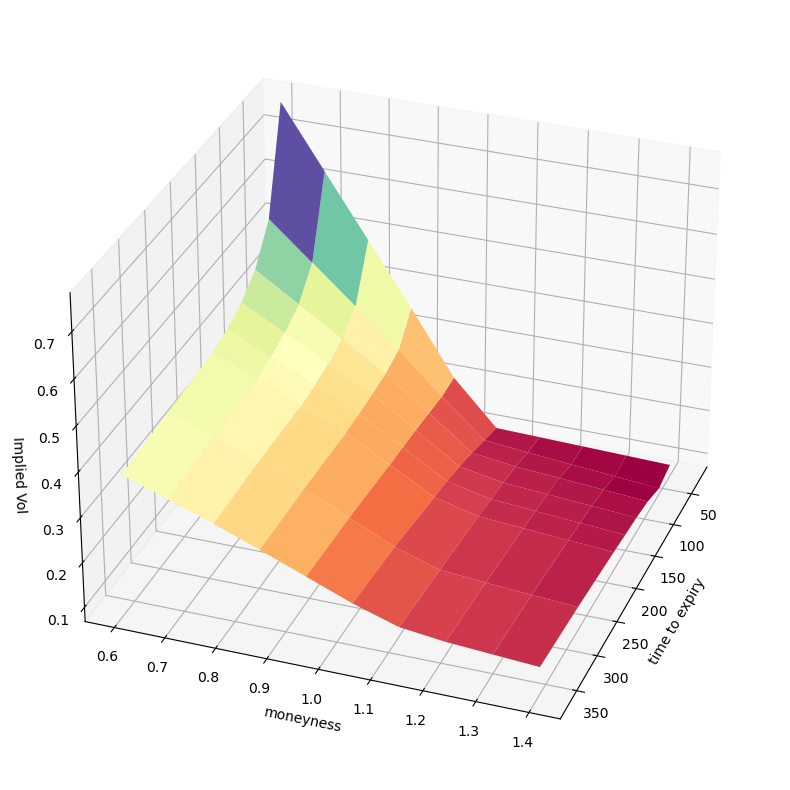

In [11]:
#create surface

tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
v=pd.pivot(interpolated_df,index=['moneyness'],columns=['days'],values='impl_volatility').to_numpy()
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,v,cmap='Spectral')
ax.set_ylabel('moneyness')
ax.set_xlabel('time to expiry')
ax.set_zlabel('Implied Vol')
ax.view_init(azim=20)
plt.show()

In [12]:
def interpolate_impliedvol(moneyness, tau, df):
    """
    Calculate implied volatility by linear interpolation first in moneyness and then time to maturity.
    
    Args:
    - moneyness (float): The moneyness value,
    - tau (float): The time to maturity,
    - df (pandas.DataFrame): The DataFrame containing the moneyness, tau, and impliedvol columns.
    
    Returns:
        float: The interpolated impliedvol value.
    """
    # Sort the DataFrame by moneyness and tau
    df_sorted = df.sort_values(['moneyness', 'tau'])
    
    # Interpolate in moneyness
    moneyness_values = df_sorted['moneyness'].unique()
    impliedvol_values = [df_sorted.loc[df_sorted['moneyness']==m, 'impliedvol'].values for m in moneyness_values]
    impliedvol_interp = pd.Series(impliedvol_values, index=moneyness_values).interpolate(method='linear')(moneyness)
    
    # Interpolate in tau
    tau_values = df_sorted['tau'].unique()
    impliedvol_values = [df_sorted.loc[df_sorted['tau']==t, 'impliedvol'].values for t in tau_values]
    impliedvol_interp = pd.Series(impliedvol_values, index=tau_values).interpolate(method='linear')(tau)
    
    return impliedvol_interp


In [13]:
#Next is to implement arbitrage penalties
pd.pivot(interpolated_df,index=['moneyness'],columns=['days'],values='impl_volatility')
interpolated_df

,date,days,impl_volatility,cp_flag,ticker,rate,moneyness
0,2021-12-31,30,0.662555,C,NDX,0.005311,0.600000
1,2021-12-31,30,0.557275,C,NDX,0.005311,0.688889
2,2021-12-31,30,0.451995,C,NDX,0.005311,0.777778
3,2021-12-31,30,0.346715,C,NDX,0.005311,0.866667
4,2021-12-31,30,0.235843,C,NDX,0.005311,0.955556
...,...,...,...,...,...,...,...
75,2021-12-31,365,0.236140,C,NDX,0.006907,1.044444
76,2021-12-31,365,0.211065,C,NDX,0.006907,1.133333
77,2021-12-31,365,0.198036,C,NDX,0.006907,1.222222
78,2021-12-31,365,0.194360,C,NDX,0.006907,1.311111


In [14]:
def c(m,tao,r,sigma):
    #calculate call price
    d1=(-np.log(m)+tao*(r+sigma**2/2))/(sigma*np.sqrt(tao))
    d2=(-np.log(m)+tao*(r-sigma**2/2))/(sigma*np.sqrt(tao))
    return norm.cdf(d1)-m*np.exp(-r*tao)*norm.cdf(d2)

#calendar spread arbitrage penalty
def p1(df,matrix=False):
    '''
    Takes an interpolated dataframe containing:
    'days' - days to expiry
    'impl_volatility' -implied volatility
    'rate' - interest rate
    'moneyness' - ratio of asset price and strike
    'c' - call price
    if matrix is true return the surface of p1
    '''
    df['time']=df['days']/365
    pivot_df=pd.pivot(df,index=['time'],columns=['moneyness'],values='c')
    pivot_df=pivot_df-pivot_df.shift(-1)
    time_diff=np.diff(pivot_df.index.to_numpy())
    
    pivot_df=pivot_df.iloc[:-1]
    #divide by time difference and multiply by time
    
    #in the paper for the sum they have mutliply by tj but not in the matrix version is this a typo?
    if(matrix):
        pivot_df=pivot_df.T/time_diff
        pivot_df=np.maximum(pivot_df,0)
        #insert boundary as 0's
        pivot_df.insert(len(pivot_df.columns),1,np.zeros(len(pivot_df.index)))
        return pivot_df
    else:
        pivot_df=pivot_df.T/time_diff*pivot_df.index
        pivot_df=np.maximum(pivot_df,0)
    
    #now sum across columns and rows
    p1=pivot_df.sum().sum()
    return p1

In [15]:
#call spread arbitrage penalty
def p2(df,matrix=False):
    '''
    Takes an interpolated dataframe containing:
    'days' - days to expiry
    'impl_volatility' -implied volatility
    'rate' - interest rate
    'moneyness' - ratio of asset price and strike
    'c' - call price
    if matrix is true return the surface of p1
    '''
    df['time']=df['days']/365
    max_m=max(df['moneyness'].unique())
    pivot_df=pd.pivot(df,index=['moneyness'],columns=['time'],values='c')
    pivot_df=pivot_df.shift(-1)-pivot_df
    money_diff=np.diff(pivot_df.index.to_numpy())
    pivot_df=pivot_df.iloc[:-1]
    #divide by difference in moneyness
    pivot_df=pivot_df.T/money_diff
    pivot_df=np.maximum(pivot_df,0)
    if(matrix):
        pivot_df.insert(len(pivot_df.columns),max_m,np.zeros(len(pivot_df.index)))
        return pivot_df.T
    else:
        return pivot_df.sum().sum()

In [16]:
#butterfly spread arbitrage penalty
def p3(df,matrix=False):
    '''
    Takes an interpolated dataframe containing:
    'days' - days to expiry
    'impl_volatility' -implied volatility
    'rate' - interest rate
    'moneyness' - ratio of asset price and strike
    'c' - call price
    if matrix is true return the surface of p1
    '''
    df['time']=df['days']/365
    
    #second term
    pivot_df=pd.pivot(df,index=['moneyness'],columns=['time'],values='c')
    df_1=pivot_df.shift(-1)-pivot_df
    money_diff=np.diff(pivot_df.index.to_numpy())
    df_1=df_1.iloc[:-1]
    df_1=df_1.T/money_diff
    
    #frist term
    df_2=pivot_df-pivot_df.shift(1)
    df_2=df_2.iloc[1:]
    df_2=df_2.T/money_diff
    
    df_3=df_2-df_1
    #df_3=df_3.iloc[:,1:-1]
    df_3=df_3.fillna(0)
    df_3=np.maximum(df_3,0)
    if(matrix):
        return df_3.T
    else:
        return df_3.sum().sum()

Skipping part about perturbations, not sure if it's ever used again

### Interpolating Interest Rates

In [17]:
#interpolate interest rates to work with volsurf_df
zero_curve

,date,days,rate
0,2000-01-03,7,0.059296
1,2000-01-03,16,0.059142
2,2000-01-03,44,0.060177
3,2000-01-03,72,0.060907
4,2000-01-03,107,0.061550
...,...,...,...
250023,2021-12-31,182,0.005868
250024,2021-12-31,273,0.006338
250025,2021-12-31,365,0.006907
250026,2021-12-31,547,0.008269


In [18]:
day_list=np.array([30,60,91,122,152,182,273,365])

In [19]:
#make a new dataframe with these days
dates=zero_curve['date'].unique()

rep_days=np.tile(day_list,len(dates))
rep_dates=np.repeat(dates,len(day_list))
df_to_merge=pd.DataFrame(np.vstack((rep_dates,rep_days)).T,columns=['date','days'])

#now merge dfs to make na's so we can interpolate
merged_df=pd.merge(zero_curve, df_to_merge, how='outer', on=['date','days'])
merged_df=merged_df.sort_values(['date','days'])
merged_df['days']=merged_df['days'].astype(int)
merged_df=merged_df.set_index(['days'])

for date in dates:
    merged_df[merged_df['date']==date]=merged_df[merged_df['date']==date].interpolate(method='spline',order=3)

C:\Users\david\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


In [20]:
interpolated_rates=merged_df

In [21]:
interpolated_rates=interpolated_rates.reset_index()

In [22]:
#add rates to volsurface dataframe
impl_vol_df=pd.merge(volsurf_df,interpolated_rates,how='left',left_on=['date','days'],right_on=['date','days'])

#some dates were not included in the zero_curve file, interpolate for these
for days in impl_vol_df['days'].unique():
    impl_vol_df[impl_vol_df['days']==days]=impl_vol_df[impl_vol_df['days']==days].interpolate(method='spline',order=3)

#calculate moneyness
impl_vol_df['moneyness']=impl_vol_df.apply(lambda x: inverse_delta(x.delta,x.days/365,x.rate,x.impl_volatility),axis=1)

In [23]:
#impl_vol_df['c']=impl_vol_df.apply(lambda row: c(row['moneyness'],row['days']/365,row['rate'],row['impl_volatility']),axis=1)

Need to create a fixed grid for m, so that we can create a proper surface when calculating the arbitrage penalties

In [54]:
def interpolate_moneyness(df,m_grid):
    '''
    Takes as argument a dataframe with:
    days,moneyness,inpl_volatility columns, delta and c
    
    Returns:
    Dataframe with implied volatility values linearly interpolated to fit the gird of
    moneyness values
    '''
    #m_grid=np.linspace(0.6,1.4,10)
    t_grid=df['days'].unique()
    
    #interpolate in moneyness
    df=df.sort_values(['days','moneyness'])
    interpolated_points=[]
    interpolated_df=pd.DataFrame()
    
    for t in t_grid:
        sub_df=df[df['days']==t]
        #interpolation function
        '''
        f=interpolate.interp1d(sub_df['moneyness'],sub_df['impl_volatility'],fill_value='extrapolate')
        #use structure of sub_df to set up new data frame of interpolated points
        sub_df=sub_df[:10]
        interpolated_points=f(m_grid)
        #replace columns for new interpolated grid
        sub_df['moneyness']=m_grid
        sub_df['impl_volatility']=interpolated_points
        '''
        #Alternate interpolation:
        interpolated_points=np.interp(m_grid,sub_df['moneyness'],sub_df['impl_volatility'])
        sub_df=sub_df[:10]
        #replace columns for new interpolated grid
        sub_df['moneyness']=m_grid
        sub_df['impl_volatility']=interpolated_points

        interpolated_df=pd.concat([interpolated_df,sub_df],ignore_index=True)
        interpolated_df.drop(columns=['delta'],inplace=True)
        #delta no longer accurate
    return interpolated_df

In [25]:
m_grid=np.linspace(0.6,1.4,10)
interp_implvol_df=pd.DataFrame([])

dates=impl_vol_df['date'].unique()
for date in dates:
    temp_df=impl_vol_df[impl_vol_df['date']==date]
    interp_implvol_df=pd.concat([interp_implvol_df,interpolate_moneyness(temp_df,m_grid)])

In [26]:
#now calculate call values
interp_implvol_df['c']=interp_implvol_df.apply(lambda row: c(row['moneyness'],row['days']/365,row['rate'],row['impl_volatility']),axis=1)

In [27]:
p1_vals=interp_implvol_df.groupby('date').apply(p1)
p2_vals=interp_implvol_df.groupby('date').apply(p2)
p3_vals=interp_implvol_df.groupby('date').apply(p3)
ptot_vals=p1_vals+p3_vals+p2_vals

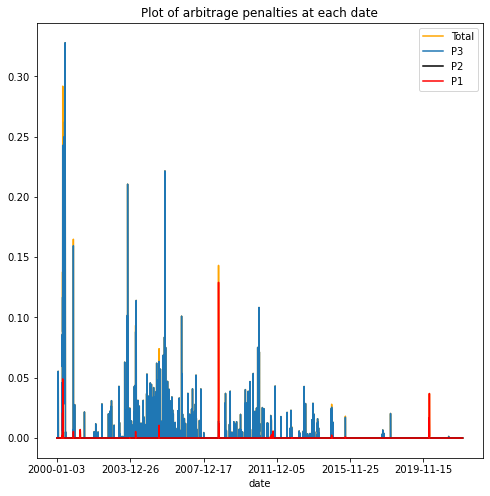

In [28]:
ptot_vals.plot(figsize=(8,8),label='Total',color='orange')
p3_vals.plot(figsize=(8,8),label='P3')
p2_vals.plot(figsize=(8,8),label='P2',color='black')
p1_vals.plot(figsize=(8,8),label='P1',color='red')
plt.title("Plot of arbitrage penalties at each date")

plt.legend()

Interesting that the types of arbitrages seem to reveal other conditions.

In [48]:
test_sample=interp_implvol_df[interp_implvol_df['date']=='2008-10-09']

C:\Users\david\AppData\Local\Temp\ipykernel_23288\695296352.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time']=df['days']/365


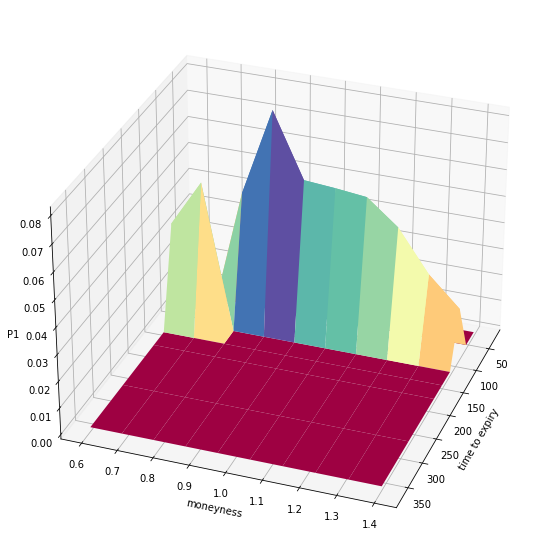

In [49]:
m_grid=np.linspace(0.6,1.4,10)
tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,p1(test_sample,matrix=True).to_numpy(),cmap='Spectral')
ax.set_ylabel('moneyness')
ax.set_xlabel('time to expiry')
ax.set_zlabel('P1')
ax.view_init(azim=20)
plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_23288\1963606714.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time']=df['days']/365


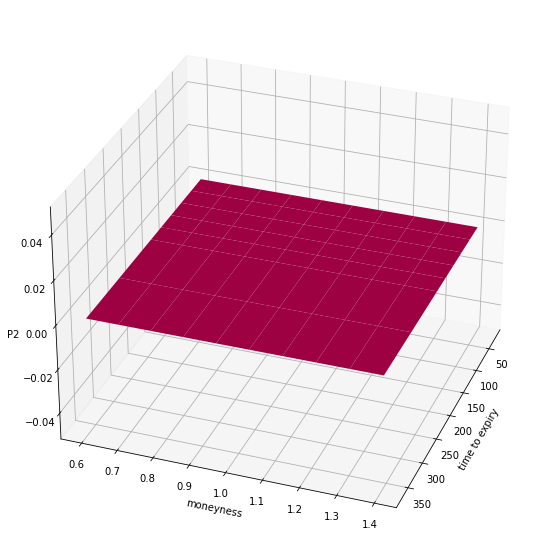

In [50]:
m_grid=np.linspace(0.6,1.4,10)
tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,p2(test_sample,matrix=True).to_numpy(),cmap='Spectral')
ax.set_ylabel('moneyness')
ax.set_xlabel('time to expiry')
ax.set_zlabel('P2')
ax.view_init(azim=20)
plt.show()

In [33]:
#test_sample=interp_implvol_df[interp_implvol_df['date']=='2005-11-11']

C:\Users\david\AppData\Local\Temp\ipykernel_23288\2512577131.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time']=df['days']/365


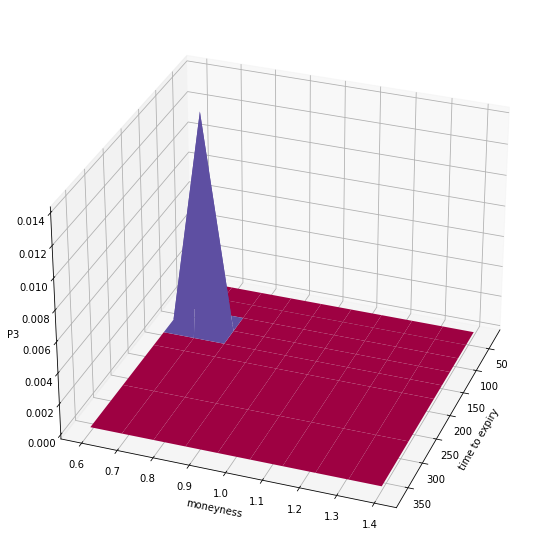

In [51]:
m_grid=np.linspace(0.6,1.4,10)
tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,p3(test_sample,matrix=True).to_numpy(),cmap='Spectral')
ax.set_ylabel('moneyness')
ax.set_xlabel('time to expiry')
ax.set_zlabel('P3')
ax.view_init(azim=20)
plt.show()

Repeating the above on a smaller grid

In [55]:
m_grid=np.linspace(0.8,1.2,10)
interp_implvol_df2=pd.DataFrame([])

dates=impl_vol_df['date'].unique()
for date in dates:
    temp_df=impl_vol_df[impl_vol_df['date']==date]
    interp_implvol_df2=pd.concat([interp_implvol_df2,interpolate_moneyness(temp_df,m_grid)])

In [56]:
interp_implvol_df2['c']=interp_implvol_df2.apply(lambda row: c(row['moneyness'],row['days']/365,row['rate'],row['impl_volatility']),axis=1)

In [57]:
p1_vals=interp_implvol_df.groupby('date').apply(p1)
p2_vals=interp_implvol_df.groupby('date').apply(p2)
p3_vals=interp_implvol_df.groupby('date').apply(p3)
ptot_vals=p1_vals+p3_vals+p2_vals

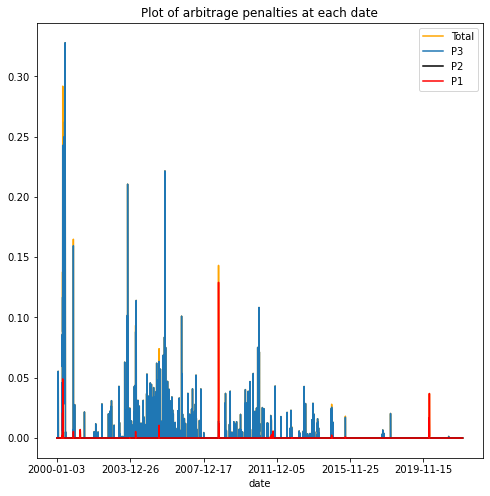

In [58]:
ptot_vals.plot(figsize=(8,8),label='Total',color='orange')
p3_vals.plot(figsize=(8,8),label='P3')
p2_vals.plot(figsize=(8,8),label='P2',color='black')
p1_vals.plot(figsize=(8,8),label='P1',color='red')
plt.title("Plot of arbitrage penalties at each date")

plt.legend()

How is the total smaller than the P1

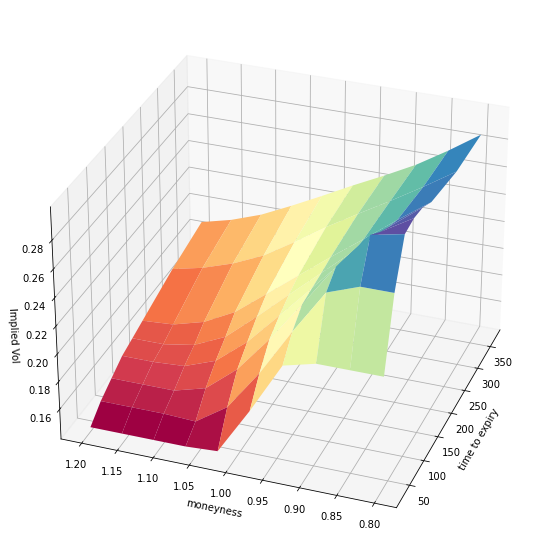

In [65]:
sample_df=interp_implvol_df2[interp_implvol_df2['date']=='2021-11-01']
tt,mm=np.meshgrid(t_grid,m_grid)
#volatility indexed by moneyess and days to expiry
v=pd.pivot(sample_df,index=['moneyness'],columns=['days'],values='impl_volatility').to_numpy()
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(tt,mm,v,cmap='Spectral')
ax.set_ylabel('moneyness')
ax.set_xlabel('time to expiry')
ax.set_zlabel('Implied Vol')
ax.view_init(azim=200)
plt.show()

## NW Smoothing

In [52]:
def NWSmooth(df,t,h1,h2,m,tau):
    '''
    Arguments:
    df-dataframe
    t-desired date
    h1,h2-bandwith parameters
    m-moneyness value desired
    tau-time to expiry desired
    
    returns:
    volatility value on NW-Smoothed plane at that time
    '''
    m_grid=df['moneyness'].unique()
    t_grid=df['days'].unique()
    t_grid=t_grid/365
    df_t=df[df['date']==t]
    g=lambda x,y:1/(2*np.pi)*np.exp(-x**2/(2*h1))*np.exp(-y**2/(2*h2))
    df_t['time']=df_t['days']/365
    pivot_df=pivot_df=pd.pivot(df_t,index=['moneyness'],columns=['time'],values='impl_volatility')
    g_vals=np.zeros([len(m_grid),len(t_grid)])
    for i,m_val in enumerate(m_grid):
        for j,t_val in enumerate(t_grid):
            
            g_vals[i,j]=g(m-m_val,tau-t_val)
    
    g_vals=g_vals
    pivot_df=pivot_df*g_vals
    return pivot_df.sum().sum()/np.sum(g_vals)

In [53]:
NWSmooth(interp_implvol_df,'2000-01-03',1,1,1,1)

C:\Users\david\AppData\Local\Temp\ipykernel_23288\2959514247.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['time']=df_t['days']/365


0.4351654559095324

## Getting spline functions of a surface

In [126]:
interp_implvol_df

,date,days,impl_volatility,cp_flag,ticker,rate,moneyness,c
0,2000-01-03,30,0.407603,C,SPX,0.060394,0.600000,0.402971
1,2000-01-03,30,0.367306,C,SPX,0.060394,0.688889,0.314526
2,2000-01-03,30,0.327008,C,SPX,0.060394,0.777778,0.226152
3,2000-01-03,30,0.286711,C,SPX,0.060394,0.866667,0.138710
4,2000-01-03,30,0.241921,C,SPX,0.060394,0.955556,0.058401
...,...,...,...,...,...,...,...,...
75,2021-12-31,365,0.187761,C,SPX,0.006907,1.044444,0.058998
76,2021-12-31,365,0.155810,C,SPX,0.006907,1.133333,0.021310
77,2021-12-31,365,0.143686,C,SPX,0.006907,1.222222,0.006483
78,2021-12-31,365,0.136809,C,SPX,0.006907,1.311111,0.001595


First step is to compute log vol returns

In [212]:
interp_implvol_df=interp_implvol_df.sort_values(['days','moneyness','date'])
interp_implvol_df['log_IV']=np.log(interp_implvol_df['impl_volatility'])
interp_implvol_df['IV_ret']=interp_implvol_df.groupby(['days','moneyness']).log_IV.diff()
interp_implvol_df['IV_ret']=interp_implvol_df['IV_ret'].fillna(0)

In [342]:
flattened_covariance=[]
index=[]
for comb in itertools.combinations_with_replacement(interp_implvol_df.groupby(['days','moneyness']).IV_ret,2):
    #get the covariance between every moneyness and expiry time combination across all dates
    flattened_covariance.append(np.cov(comb[0][1],comb[1][1])[0,1])
    index.append((comb[0][0],comb[1][0]))
flattened_covariance=np.array(flattened_covariance)    
#now have upper triangle of covariance matrix inclduing diagonal

#construct the covariance matrix
ind = np.triu_indices(80)
cov_mat=np.zeros([80,80])
cov_mat[ind]=flattened_covariance

diag=np.diag(cov_mat)
cov_mat=cov_mat+cov_mat.T-np.diag(diag) # get lower triangle

In [270]:
sample_df=interp_implvol_df[interp_implvol_df['date']=='2000-01-05']

knots_x=np.array([0.6,0.6,0.6,1.4,1.4,1.4])
knots_x=np.insert(knots_x,3,np.linspace(0.6,1.4,3))

knots_y=np.array([30,30,30,365,365,365])
knots_y=np.insert(knots_y,3,np.linspace(30,365,3))

In [265]:
interpolate.bisplrep(x=sample_df['moneyness'],y=sample_df['days'],z=sample_df['IV_ret'],task=-1,tx=knots_x,ty=knots_y,kx=3,ky=3)

[array([0.6, 0.6, 0.6, 0.6, 1. , 1.4, 1.4, 1.4, 1.4]),
 array([ 30.,  30.,  30.,  30., 197., 365., 365., 365., 365.]),
 array([-0.00079465,  0.01457221, -0.02728514, -0.01598784, -0.02791161,
         0.01494984,  0.01246054, -0.02630087, -0.02970984, -0.03493086,
        -0.03147983,  0.00451599, -0.00160097,  0.03056006,  0.02012111,
         0.0035615 ,  0.03496126, -0.00456725,  0.00118815, -0.00673161,
        -0.0040576 ,  0.02863879, -0.00866667,  0.01921884,  0.0047103 ]),
 3,
 3]

Covariance function

##In the following cells we develop the reweighting approach for Montecarlo simulations, giving lower weights to the penalised paths. The bigger the static arbitrage present, the bigger penalization.

A path is a realization of the evolution of the volatility surface:
$$(S_t(w_i), \sigma_t(m,\tau,w_i);t\in \{0, \dots  t_{max}\})$$
under the measure $\mathbb{P}_0$ (physical dynamics). 

Once we have a simulation of $N$ paths we add a weight to each path as following:
$$w_i(\beta):= \frac{exp(-\beta \phi(w_i))}{\sum_{j=1}^N exp(-\beta \phi(w_j))}$$

The paths parameters of the following function is expected to be a dataframe whose columns represent a path simulation

In [12]:
def call(m, tau, sigma, r):
    '''
    Function that retuns the price of a European Call given:
    - m     moneyness
    - tau   time to maturity
    - sigma volatility
    - r     interest rate
    '''
    d1 = (np.log(m)+ tau * (r + sigma**2 / 2)) / (sigma * np.sqrt(tau))
    d2 = (np.log(m)+ tau * (r - sigma**2 / 2)) / (sigma * np.sqrt(tau))
    return norm.cdf(d1) - m * np.exp(-r * tau) * norm.cdf(d2)

In [13]:
def MCWEIGHTING(paths, beta, T):
    """
    This functions reweights the simulations giving a greater weight 
    to those with less or no arbitrage

    Parameters:
    - paths simulated paths of under choosen dynamics (insert as a numpy 3d array)
    - beta  arbitrage tolerance parameter, big beta means small arbitrage tolerance
    - T     time to maturity
    Return:
    - The weighted average of the simulated paths to reduce the arbitrage.
    """
    
    m,n,r = paths.shape
    out_arr = np.column_stack((np.repeat(np.arange(m),n),paths.reshape(m*n,-1)))
    out_df = pd.DataFrame(out_arr)
    out_df.columns = ['omega', 'time', 'S_t', 'Vol_t']
    out_df['moneyness'] = K / out_df['S_t']
    out_df['tau'] = np.abs(T - out_df['time'])
    
    out_df['p1'] =  out_df['tau'] * (call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'], out_df['tau'].shift(1), out_df['Vol_t'], r)) /(out_df['tau'] - out_df['tau'].shift(1))
    out_df['p2'] =  (call(out_df['moneyness'].shift(1), out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)) /(out_df['moneyness'].shift(1) - out_df['moneyness'])
    out_df['p3'] = (call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'].shift(-1), out_df['tau'], out_df['Vol_t'], r)) /(out_df['moneyness'] - out_df['moneyness'].shift(-1)) - (call(out_df['moneyness'].shift(1), out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)) /(out_df['moneyness'].shift(1) - out_df['moneyness'])

    #I have a bottleneck in eliminating the penalization in the following:
    #review the indexing in section 4 and figure out what is wrong

    #After fixing the indexing:
    out_df['totalpen'] = out_df['p1'] + out_df['p2'] + out_df['p3']

    # Group the DataFrame by the 'omega' column and sum the 'p1', 'p2', and 'p3' columns
    grouped_df = np.exp(-beta * out_df.groupby('omega')['totalpen'].sum())

    # Sum the totalpenalization column and assign the result to a new DataFrame:
    sumpen = grouped_df.sum()

    #We calculate the weights:
    weights = grouped_df/sumpen

    # Compute the weighted average of the simulations
    weighted_avg = np.dot(weights, paths)

    # Print the result
    print(weighted_avg)
    

    

In [14]:
N = 10
M = 5
r = 0.05
K = 100
T = 1
a = np.abs(np.random.normal(0, 10, (M, M, 3)))

m,n,r = a.shape
out_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))
out_df = pd.DataFrame(out_arr)
out_df.columns = ['omega', 'time', 'S_t', 'Vol_t']
out_df['moneyness'] = K / out_df['S_t']
out_df['tau'] = np.abs(T - out_df['time'])
out_df

,omega,time,S_t,Vol_t,moneyness,tau
0,0.0,12.525212,12.514760,5.944891,7.990565,11.525212
1,0.0,12.820622,2.348149,1.234992,42.586743,11.820622
2,0.0,0.891700,25.213581,5.323072,3.966117,0.108300
3,0.0,10.924394,3.662447,12.076332,27.304152,9.924394
4,0.0,0.036389,1.410508,3.864641,70.896466,0.963611
5,1.0,17.320667,29.741007,12.984483,3.362361,16.320667
6,1.0,4.815394,8.653355,3.840295,11.556211,3.815394
7,1.0,6.863752,1.190115,14.685876,84.025492,5.863752
8,1.0,14.082836,12.800946,7.895485,7.811923,13.082836
9,1.0,2.503761,5.726832,16.310534,17.461662,1.503761


In [88]:
out_df['p1'] =  out_df['tau'] * (call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'], out_df['tau'].shift(1), out_df['Vol_t'], r)) /(out_df['tau'] - out_df['tau'].shift(1))
out_df['p2'] =  (call(out_df['moneyness'].shift(1), out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)) /(out_df['moneyness'].shift(1) - out_df['moneyness'])
out_df['p3'] = (call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'].shift(-1), out_df['tau'], out_df['Vol_t'], r)) /(out_df['moneyness'] - out_df['moneyness'].shift(-1)) - (call(out_df['moneyness'].shift(1), out_df['tau'], out_df['Vol_t'], r)-call(out_df['moneyness'], out_df['tau'], out_df['Vol_t'], r)) /(out_df['moneyness'].shift(1) - out_df['moneyness'])
out_df['totalpen'] = out_df['p1'] + out_df['p2'] + out_df['p3']

In [89]:
out_df

,omega,time,S_t,Vol_t,moneyness,tau,p1,p2,p3,totalpen
0,0.0,16.874983,11.353134,1.249685,8.808140,15.874983,NaN,NaN,NaN,NaN
1,0.0,6.071490,6.978858,6.284948,14.328992,5.071490,5.055374e-15,-9.652624e-16,7.758924e-18,4.097871e-15
2,0.0,13.350529,12.953611,6.141942,7.719855,12.350529,2.354679e-14,0.000000e+00,-0.000000e+00,2.354679e-14
3,0.0,12.822729,4.236476,20.917482,23.604524,11.822729,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00
4,0.0,8.013542,8.213686,15.271308,12.174802,7.013542,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00
5,1.0,15.456668,1.671385,6.058733,59.830617,14.456668,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00
6,1.0,0.038816,0.959853,13.255107,104.182594,0.961184,6.753606e-10,-1.191428e-10,1.598328e-11,5.722011e-10
7,1.0,10.548960,4.776985,3.353275,20.933705,9.548960,7.332751e-01,-9.578052e-15,2.305329e-15,7.332751e-01
8,1.0,20.930003,6.807313,3.378146,14.690084,19.930003,1.357738e-13,0.000000e+00,-0.000000e+00,1.357738e-13
9,1.0,17.855557,6.774697,5.118034,14.760807,16.855557,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00


In [90]:
beta = 1

# Group the DataFrame by the 'omega' column and sum the 'p1', 'p2', and 'p3' columns
grouped_df = np.exp(-beta * out_df.groupby('omega')['totalpen'].sum())

# Print the resulting DataFrame
print(grouped_df)

# Sum the totalpenalization column and assign the result to a new DataFrame
sumpen = grouped_df.sum()

# Print the resulting DataFrame
print(sumpen)

#We calculate the weights:
weights = grouped_df/sumpen

print(weights)

# Compute the weighted average of the simulations
weighted_avg = np.dot(weights, a)

# Print the result
print(weighted_avg)
print(out_arr)

omega
0.0    1.000000e+00
1.0    4.803333e-01
2.0    1.000501e+00
3.0    9.532325e-01
4.0    6.410093e-16
Name: totalpen, dtype: float64
3.4340671782965115
omega
0.0    2.911999e-01
1.0    1.398730e-01
2.0    2.913459e-01
3.0    2.775812e-01
4.0    1.866618e-16
Name: totalpen, dtype: float64
[[13.21220117  9.2321329   8.83873233]
 [13.38958116  3.9023019   5.53300691]
 [ 6.33031776  7.38343266 10.42938079]
 [15.65589174  8.52990276 10.78422521]
 [ 3.8968012   4.01444419  8.64128388]]
[[ 0.         16.87498337 11.35313445  1.24968498]
 [ 0.          6.07148986  6.97885795  6.28494849]
 [ 0.         13.35052852 12.95361075  6.14194194]
 [ 0.         12.82272881  4.2364761  20.91748243]
 [ 0.          8.01354248  8.2136858  15.27130795]
 [ 1.         15.456668    1.67138506  6.05873294]
 [ 1.          0.03881561  0.95985324 13.2551075 ]
 [ 1.         10.54895988  4.77698525  3.35327533]
 [ 1.         20.93000334  6.80731288  3.37814619]
 [ 1.         17.855557    6.77469714  5.11803381]
 

#Simulating Dynamics



Before we are able to weight them we need to simulate the MC

Before we are able to weight them we need to simulate the MC

In [15]:
def surface(Xsim, f1, f2, f3, sigma0):
    """
    Parameters:

    Inside the lambda:
    - m a value of moneyness
    - tau a time to maturity

    Of the function:
    - Xsim a simulation of the path under chosen dynamics of the x's
    - f1(m, tau) all three are basis functions
    - f2(m, tau)
    - f3(m, tau)
    - sigma0 is a function of the initial volatility for m and tau
    Returns:
    - Volatility under the three factor model.
    """
    return lambda m, tau: sigma0(m, tau) * np.exp(Xsim[0] * f1(m, tau) + Xsim[1] * f2(m, tau) + Xsim[2] * f3(m, tau))


In [16]:
#We test that it works. The f1, f2, f3 and other parameters are totally arbitrary:

def f1(m, tau):
    return 0.87

def f2(m, tau):
    return 1.2 / 8 * m 

def f3(m, tau):
    return (m**2 - 0.3)*(tau)

def sigma0(m, tau):
    return 0.5

sigma = surface([0.8, 0.5, 1], f1, f2, f3, sigma0)

sigma(1,0)

1.080963550140939

The following pieces of code simulate a path of $(S_t(w_i), \sigma_t(m,\tau,w_i);t\in \{0, \dots  t_{max}\})$ under the following dynamics:

$$X_t = (x_t^1, x_t^2, x^3_t)$$
a random vector in $R^3$ where the components represent the level, skew and curvature coefficients. 
Each coordinate is an independent Ornstein-Uhlenbeck procees:
$$dx_t^i=-\lambda^i x_t^i dt +\gamma^i dW_t^i$$

Under an Eurler Scheme:

In [17]:
#We will never really use this function as we use it integrated inside the simVECTORIALpath

def simXpath(N, lambdaVec, gammaVec, X_0Vect):

    h = 1 / 365 #We assume the jump between days is a calendar day distance to avoid over complications
    sqrth = np.sqrt(h)

    X = np.zeros((N,3))
    # generates a N x 3 matrix of (0, 1) normals
    normals =  np.random.normal(size = (N, 3)) 
    X[0] = X_0Vect #Vector of initial values
    
    for n in range(1,N):
        X[n] = X[n-1] - lambdaVec * X[n-1] * h + gammaVec * normals[n-1] * sqrth

    return X

The price of the underlying is modelled as:
$$dS_t = \sigma_t(1,0)dW_t^0$$
where $$W^0 = \rho W^1 + \sqrt{1-\rho^2} B$$

In [18]:
def simVECTORIALpath(N, lambdaVec, gammaVec, X_0Vect, sigma0, f1, f2, f3, S0, rho = -0.5):
    """
    This function simulates a joint path of the coefficient of the bassi functions together with a path for the underlying price
    Inputs:
    - N          number of periods to simulate the path in
    - lambdaVec  lambda parameters for the OU model
    - gammaVec   gamma parameters for the OU model
    - X_0Vec     a initial point to simulate the OU under an Euler scheme
    - rho        the correlation of the Brownian motions, the default is -0.5 as in the paper
    - f1         level basic function
    - f2         skew basic function
    - f3         curvature basic function
    - S0         a initial price of the underlying for the Euler scheme simulation, no default but normally take the price of
                the underlying the first day we have available data.

    Output:
    - Numpy array [S,X] being S the price process simulation and X the X process simulation.
    the shape is an array with N entries (periods) of dimension 4 being the first one for each period the pirce S_t.
    """


    h = 1 / 365 #We assume the jump between days is a calendar day distance to avoid over complications
    sqrth = np.sqrt(h)

    #We first generate the paths for the x^i_t
    X = np.zeros((N,3))
    # generates a N x 3 matrix of (0, 1) normals
    normals =  np.random.normal(size = (N, 3)) 
    X[0] = X_0Vect #Vector of initial values
    
    for n in range(1,N):
        X[n] = X[n-1] - lambdaVec * X[n-1] * h + gammaVec * normals[n-1] * sqrth


    #We now use the path to generate the implied vol surface sigma_t(m, tau)
    #In particular we need this to have sigma_t(1,0) to generate the asset path.

    sigma_1_0 = np.zeros(N)
    sigma_1_0[0] = sigma0

    for n in range(1,N):
        sigma_1_0[n] = sigma0 * np.exp(X[n,0]*f1(1, 0) + X[n,1]*f2(1, 0) +X[n,2]*f3(1, 0))
    
    #Now we simulate the Brownian motion that drives the asset:
    W = rho * normals[:,0] + np.sqrt(1-rho**2) * np.random.normal(size = N)

    #Finally we compute S_t:
    S = np.zeros(N)
    S[0] = S0
    for n in range(1,N):
        S[n] = S[n-1] + sigma_1_0[n] * W[n]

    result = np.concatenate((S[:, np.newaxis], X), axis=1)
    return result

In [19]:
#The following cell is a simple check that the function properly works, so the parameter values are arbitrary.

def f1(m, tau):
    return 0.87

def f2(m, tau):
    return 1.2 / 8 * m 

def f3(m, tau):
    return (m**2 - 0.3)*(tau)


N = 1000
lambdaVec = [0.035, 0.08, 0.045]
gammaVec = [0.035, 0.08, 0.045]
X_0Vect = [0, 0, 0]
sigma0 = 0.5
S0 = 100
Xsim = simVECTORIALpath(N, lambdaVec, gammaVec, X_0Vect, sigma0, f1, f2, f3, S0, rho = -0.5)

In [20]:
Xsim

array([[ 1.00000000e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 9.96535236e+01, -2.72757771e-04, -1.65181355e-03,
         5.14874907e-03],
       [ 9.98995635e+01,  7.24428226e-04,  5.83394014e-04,
         3.24129911e-03],
       ...,
       [ 9.51776707e+01,  1.54387356e-02,  9.57087669e-02,
        -5.26243593e-02],
       [ 9.51365534e+01,  1.38117517e-02,  9.29026724e-02,
        -5.29347942e-02],
       [ 9.48464708e+01,  1.35943293e-02,  9.10350040e-02,
        -5.23407828e-02]])

In [21]:
#testing that it works:

def sigma0(m, tau):
    return 0.5

n = 0
sigma_t = surface([Xsim[n,1], Xsim[n,2], Xsim[n,3]], f1, f2, f3, sigma0)
sigma_t(1,0)

0.5

Now we focus on transforming a path generated as above into a surface (thought as a vector field)

In [22]:
def sigma0(m, tau):
    return 0.5

# create some example data
moneyness = np.linspace(0.8, 1.2, 5)
taus = np.linspace(0.1, 1.0, 10)

# create a joint grid
mgrid, tgrid = np.meshgrid(moneyness, taus, indexing='ij')

path =[]
for n in range(len(Xsim)):
    sigma_t = surface([Xsim[n,1], Xsim[n,2], Xsim[n,3]], f1, f2, f3, sigma0)

    triples = np.column_stack((mgrid.flatten(), tgrid.flatten(), sigma_t(mgrid, tgrid).flatten()))
    path.append([Xsim[n,0], triples, n])

In [23]:
path = np.array(path)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_4440\2328261255.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  path = np.array(path)


We are finally ready to simulate a sample of paths for the MC before we reweight:

REMAIN TO BE DONE FOR THE FOLLOWING CELL:
-CALCULATE BASIC FUNCTIONS
-ESTIMATE LAMBDA
-ESTIMATE GAMMA
-DEDICE WHAT INITIAL NODES TO CHOOSE THAT MAKE SENSE
-CALCULATE THE INITIAL VOLATILITY SURFACE THAT IS A GOOD CHOICE

In the following cell be extremly careful when choosing the M, N and number of points in the grids as they have highly nonlinear complexity:

In [24]:
from scipy.optimize import curve_fit

# Define your data set here as a numpy array
data = np.array([
    [0.1, 0.800000, 0.500000],
    [0.1, 0.844444, 0.500000],
    [0.1, 0.888889, 0.500000],
    [0.1, 0.933333, 0.500000],
    [0.1, 0.977778, 0.500000],
    [1.0, 1.022222, 0.501340],
    [1.0, 1.066667, 0.500912],
    [1.0, 1.111111, 0.500463],
    [1.0, 1.155556, 0.499994]
])

# Separate the data into separate arrays for m, tau, and vol
m_values = data[:, 0]
tau_values = data[:, 1]
vol_values = data[:, 2]

# Define the functions you want to fit to your data
def f1(x, a, b):
    return a*x + b

def f2(xy, a, b, c, d, e):
    x, y = xy
    return (a*x**2 + b*x + c) * (d*y + e)

# Find the optimal fit for f1 using curve_fit
popt1, pcov1 = curve_fit(f1, m_values, vol_values)

# Find the optimal fit for f2 using curve_fit
popt2, pcov2 = curve_fit(f2, (m_values, tau_values), vol_values)

# Calculate the mean of the vol values
f1_mean = np.mean(vol_values)

# Print the results
print("Mean of vol values: {:.6f}".format(f1_mean))
print("Optimal fit for f1: {:.6f} * m + {:.6f}".format(*popt1))
print("Optimal fit for f2: ({:.6f} * m**2 + {:.6f} * m + {:.6f}) * ({:.6f} * tau + {:.6f})".format(*popt2))


Mean of vol values: 0.500301
Optimal fit for f1: 0.000753 * m + 0.499925
Optimal fit for f2: (-3.799529 * m**2 + 4.181167 * m + 0.180287) * (-0.006016 * tau + 0.897553)


In [16]:
np.sqrt(lambdaVec)

array([0.18708287, 0.28284271, 0.21213203])

In [27]:
M = 3                            #Number of paths we want to generate
N = 3                            #Number of days we want to generate the surfaces for
lambdaVec = np.array([0.035, 0.08, 0.045])  #Parameters of the OU dynamics Lambda
gammaVec = np.sqrt(2 * lambdaVec)  #Parameters of the OU dynamics gamma
X_0Vect = [0, 0, 0]                #Initial point for the simulation of the X random vectors
sigma0 = 0.5                       #Initial \sigma_0(1,0) needed to generate S_t path
S0 = 100                           #Initial price of the underlying for the simulation

#Chosen basic functions:
def f1(m, tau): #level (it is not dependent of the parameters)
    return 0.500301

def f2(m, tau): #Skew (it is linear only on moneyness)
    return 0.000753 * m + 0.499925

def f3(m, tau): #Curvature (linear in tau, quadratic in moneyness, product of splines)
    return (-3.799529 * m**2 + 4.181167 * m + 0.180287) * (-0.006016 * tau + 0.897553)

Xsim = simVECTORIALpath(N, lambdaVec, gammaVec, X_0Vect, sigma0, f1, f2, f3, S0, rho = -0.5)

#Implied volatility in the first period, we can take a empirical observed surface on a particular day and use it as a proxy 
def initial_surface():
    return lambda m, tau: 0.5

sigma_0 = initial_surface()

#Create the grid on which we want to construct the volatility
moneyness = np.linspace(0.8, 1.2, 7)
taus = np.linspace(0.1, 1.0, 7)

#Create a joint grid
mgrid, tgrid = np.meshgrid(moneyness, taus, indexing='ij')


paths = []
for i in range(M):
    path =[]
    for n in range(len(Xsim)):
        sigma_t = surface([Xsim[n,1], Xsim[n,2], Xsim[n,3]], f1, f2, f3, sigma_0)
        triples = np.column_stack((mgrid.flatten(), tgrid.flatten(), sigma_t(mgrid, tgrid).flatten()))
        path.append([Xsim[n,0], triples, n])
    #path = np.array(path)
    paths.append(path)

#paths = np.array(paths)

In [28]:
triples

array([[0.8       , 0.1       , 0.5013207 ],
       [0.8       , 0.25      , 0.50132606],
       [0.8       , 0.4       , 0.50133142],
       [0.8       , 0.55      , 0.50133678],
       [0.8       , 0.7       , 0.50134214],
       [0.8       , 0.85      , 0.50134751],
       [0.8       , 1.        , 0.50135287],
       [0.86666667, 0.1       , 0.50202091],
       [0.86666667, 0.25      , 0.50202558],
       [0.86666667, 0.4       , 0.50203024],
       [0.86666667, 0.55      , 0.50203491],
       [0.86666667, 0.7       , 0.50203957],
       [0.86666667, 0.85      , 0.50204424],
       [0.86666667, 1.        , 0.5020489 ],
       [0.93333333, 0.1       , 0.50288718],
       [0.93333333, 0.25      , 0.50289098],
       [0.93333333, 0.4       , 0.50289478],
       [0.93333333, 0.55      , 0.50289858],
       [0.93333333, 0.7       , 0.50290239],
       [0.93333333, 0.85      , 0.50290619],
       [0.93333333, 1.        , 0.50290999],
       [1.        , 0.1       , 0.50392035],
       [1.

In [27]:
new_lst = [[i+1, j, paths[i][j][0], paths[i][j][1][k][0], paths[i][j][1][k][1], paths[i][j][1][k][2]]
           for i in range(len(paths))
           for j in range(len(paths[i]))
           for k in range(len(paths[i][j][1]))]

# convert the new list to a NumPy array
arr = np.stack(new_lst)

print(arr)


[[  1.           0.         100.           0.8          0.1
    0.5       ]
 [  1.           0.         100.           1.2          0.1
    0.5       ]
 [  1.           1.          99.40998565   0.8          0.1
    0.49952825]
 [  1.           1.          99.40998565   1.2          0.1
    0.50697214]
 [  2.           0.         100.           0.8          0.1
    0.5       ]
 [  2.           0.         100.           1.2          0.1
    0.5       ]
 [  2.           1.          99.40998565   0.8          0.1
    0.49952825]
 [  2.           1.          99.40998565   1.2          0.1
    0.50697214]]


The following code is optimised:

In [28]:
X = np.array(paths, dtype=object)
r = 0.05
beta = 0.5
# Create an empty dataframe with desired columns
df = pd.DataFrame(columns=['omega', 'time', 'S_t', 'moneyness', 'tau', 'Vol_t'])
print(type(df))

#We make it a dataframe, it is not the most efficient method, but it is comprenhensible and still works for nt very bug simulations. 
# Flatten the multi-dimensional array using list comprehension
rows = [{'omega': i+1, 'time': X[i][j][2], 'S_t': X[i][j][0], 'moneyness': X[i][j][1][k][0], 'tau': X[i][j][1][k][1], 'Vol_t': X[i][j][1][k][2]} 
        for i in range(len(X)) for j in range(len(X[i])) for k in range(len(X[i][j][1]))]

# Create a data frame from the list of dictionaries
df = pd.DataFrame.from_records(rows)

# Sort the dataframe by omega, moneyness, and tau
df = df.reindex(columns=['omega', 'time', 'S_t', 'tau','moneyness',  'Vol_t']) #for convenience this order is better
df = df.sort_values(['omega','time','tau', 'moneyness'])


#The p1 penalization is slighty more complex as we cannot use the shift, bu we can use the equidistance for the grid:
#We calculate this distance: (in this case 0.1)
tau_values = df['tau'].unique()
jump = tau_values[1] - tau_values[0]

#Compute the penalties:
df['p1'] = df['tau'] * (call(df['moneyness'], df['tau'], df['Vol_t'], r)-call(df['moneyness'], df['tau']+jump, df['Vol_t'], r)) /(jump)
df['p2'] = (call(df['moneyness'].shift(1), df['tau'], df['Vol_t'], r)-call(df['moneyness'], df['tau'], df['Vol_t'], r)) /(df['moneyness'].shift(1) - df['moneyness'])
df['p3'] = (call(df['moneyness'], df['tau'], df['Vol_t'], r)-call(df['moneyness'].shift(-1), df['tau'], df['Vol_t'], r)) /(df['moneyness'] - df['moneyness'].shift(-1)) - (call(df['moneyness'].shift(1), df['tau'], df['Vol_t'], r)-call(df['moneyness'], df['tau'], df['Vol_t'], r)) /(df['moneyness'].shift(1) - df['moneyness'])


#We only take as penalties the positive values:
df['p1'] = df['p1'].apply(lambda x: max(0, x))
df['p2'] = df['p2'].apply(lambda x: max(0, x))
df['p3'] = df['p3'].apply(lambda x: max(0, x))


#We need to make 0 those values that should not have a penalty by 
#the indexing and have been computing in the previous way for simplicity:

# Update the value of p1 to 0 where tau is maximum
max_tau = np.max(tau_values)
df.loc[df['tau'] == max_tau, 'p1'] = 0

# Update the value of p2 to 0 where the indexing needs it to:
m_values = df['moneyness'].unique()
max_m= np.max(m_values)
df.loc[df['moneyness'] == max_m, 'p2'] = 0

# Update the value of p3 to 0 where the indexing needs it to:
second_index = m_values[0]
df.loc[df['moneyness'] == max_m, 'p3'] = 0
df.loc[df['moneyness'] == second_index, 'p3'] = 0


#After fixing the indexing:
df['totalpen'] = df['p1'] + df['p2'] + df['p3']
#### Avoid this as it is around 3GB-> df.to_csv('df.csv', index=True)

#Group the DataFrame by the 'omega' column and sum the 'p1', 'p2', and 'p3' columns
grouped_df = np.exp(-beta * df.groupby('omega')['totalpen'].sum())

# Sum the totalpenalization column and assign the result to a new DataFrame:
sumpenalizations = grouped_df.sum()

#We calculate the weights:
weights = grouped_df/sumpenalizations

# Compute the weighted average of the simulations
weighted_avg = np.dot(weights, paths)

# Print the result
print(weighted_avg)


<class 'pandas.core.frame.DataFrame'>


IndexError: index 1 is out of bounds for axis 0 with size 1

In [24]:
print(weights)

omega
1    0.5
2    0.5
Name: totalpen, dtype: float64


#FROM HERE ON IS JUST RUBBISH

In [50]:
grouped_df.to_csv('penalizaations.csv', index=True)

In [39]:
X = np.array(paths, dtype=object)
r = 0.05
beta = 0.5
# Create an empty dataframe with desired columns
df = pd.DataFrame(columns=['omega', 'time', 'S_t', 'moneyness', 'tau', 'Vol_t'])
print(type(df))

#We make it a dataframe, it is not the most efficient method, but it is comprenhensible and still works for nt very bug simulations. 
for i in range(len(X)):
    for j in range(len(X[i])):
        omega = i + 1  # Path identifier
        time = X[i][j][2]  # Period
        S_t = X[i][j][0]  # Asset price
        for k in range(len(X[i,j][1])):
            moneyness = X[i][j][1][k][0]  # Moneyness value
            tau = X[i][j][1][k][1]  # Tau value
            Vol_t = X[i][j][1][k][2]  # Volatility value

            # Add extracted values as a new row to the dataframe
            new_row = {'omega': omega, 'time': time, 'S_t': S_t, 'moneyness': moneyness, 'tau': tau, 'Vol_t': Vol_t}
            df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

# Sort the dataframe by omega, moneyness, and tau
df = df.reindex(columns=['omega', 'time', 'S_t', 'tau','moneyness',  'Vol_t']) #for convenience this order is better
df = df.sort_values(['omega','time','tau', 'moneyness'])

#The p1 penalization is slighty more complex as we cannot use the shift, bu we can use the equidistance for the grid:
#We calculate this distance: (in this case 0.1)
tau_values = df['tau'].unique()
jump = tau_values[1] - tau_values[0]

#Compute the penalties:
df['p1'] = df['tau'] * (call(df['moneyness'], df['tau'], df['Vol_t'], r)-call(df['moneyness'], df['tau']+jump, df['Vol_t'], r)) /(jump)
df['p2'] = (call(df['moneyness'].shift(1), df['tau'], df['Vol_t'], r)-call(df['moneyness'], df['tau'], df['Vol_t'], r)) /(df['moneyness'].shift(1) - df['moneyness'])
df['p3'] = (call(df['moneyness'], df['tau'], df['Vol_t'], r)-call(df['moneyness'].shift(-1), df['tau'], df['Vol_t'], r)) /(df['moneyness'] - df['moneyness'].shift(-1)) - (call(df['moneyness'].shift(1), df['tau'], df['Vol_t'], r)-call(df['moneyness'], df['tau'], df['Vol_t'], r)) /(df['moneyness'].shift(1) - df['moneyness'])


#We only take as penalties the positive values:
df['p1'] = df['p1'].apply(lambda x: max(0, x))
df['p2'] = df['p2'].apply(lambda x: max(0, x))
df['p3'] = df['p3'].apply(lambda x: max(0, x))



#We need to make 0 those values that should not have a penalty by 
#the indexing and have been computing in the previous way for simplicity:


#After fixing the indexing:
df['totalpen'] = df['p1'] + df['p2'] + df['p3']
print(df.head(20))
df.to_csv('df.csv', index=True)
newdataframe = df

#Group the DataFrame by the 'omega' column and sum the 'p1', 'p2', and 'p3' columns
grouped_df = np.exp(-beta * df.groupby('omega')['totalpen'].sum())
print(grouped_df)

# Sum the totalpenalization column and assign the result to a new DataFrame:
sumpen = grouped_df.sum()
print("sumpen->", sumpen)

#We calculate the weights:
weights = grouped_df/sumpen

# Compute the weighted average of the simulations
weighted_avg = np.dot(weights, paths)

# Print the result
print(weighted_avg)




<class 'pandas.core.frame.DataFrame'>
   omega time    S_t  tau  moneyness     Vol_t  p1        p2        p3  \
0      1    0  100.0  0.1   0.800000  1.392155   0  0.000000  0.000000   
10     1    0  100.0  0.1   0.844444  1.411747   0  0.088221  0.000000   
20     1    0  100.0  0.1   0.888889  1.432181   0  0.000000  0.000000   
30     1    0  100.0  0.1   0.933333  1.453485   0  0.000000  0.000000   
40     1    0  100.0  0.1   0.977778  1.475688   0  0.000000  0.000000   
50     1    0  100.0  0.1   1.022222  1.498823   0  0.000000  0.000000   
60     1    0  100.0  0.1   1.066667  1.522922   0  0.000000  0.000000   
70     1    0  100.0  0.1   1.111111  1.548019   0  0.000000  0.000000   
80     1    0  100.0  0.1   1.155556  1.574152   0  0.000000  0.000000   
90     1    0  100.0  0.1   1.200000  1.601359   0  0.000000  0.366916   
1      1    0  100.0  0.2   0.800000  1.440302   0  0.000000  0.334235   
11     1    0  100.0  0.2   0.844444  1.471286   0  0.000000  0.000000   


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


ValueError: shapes (20,) and (20,30,3) not aligned: 20 (dim 0) != 30 (dim 1)

In [ ]:
def MCWEIGHTING(paths, beta, r):
    """
    This functions reweights the simulations giving a greater weight 
    to those with less or no arbitrage

    Parameters:
    - paths simulated paths of under choosen dynamics (insert as a numpy 3d array)
    - beta  arbitrage tolerance parameter, big beta means small arbitrage tolerance
    Return:
    - The weighted average of the simulated paths to reduce the arbitrage.
    """
    
    X = np.array(paths, dtype=object)

    # Create an empty dataframe with desired columns
    df = pd.DataFrame(columns=['omega', 'time', 'S_t', 'moneyness', 'tau', 'Vol_t'])
    print(type(df))

    # Loop over each path and each period to extract the required values from X
    for i in range(len(X)):
        for j in range(len(X[i])):
            omega = i + 1  # Path identifier
            time = X[i][j][2]  # Period
            S_t = X[i][j][0]  # Asset price
            for k in range(len(X[i,j][1])):
                moneyness = X[i][j][1][k][0]  # Moneyness value
                tau = X[i][j][1][k][1]  # Tau value
                Vol_t = X[i][j][1][k][2]  # Volatility value

                # Add extracted values as a new row to the dataframe
                new_row = {'omega': omega, 'time': time, 'S_t': S_t, 'moneyness': moneyness, 'tau': tau, 'Vol_t': Vol_t}
                df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

    # Sort the dataframe by omega, moneyness, and tau
    df = df.sort_values(['omega','time','moneyness','tau'])
        
    df['p1'] =  df['tau'] * (call(df['moneyness'], df['tau'], df['Vol_t'], r)-call(df['moneyness'], df['tau'].shift(1), df['Vol_t'], r)) /(df['tau'] - df['tau'].shift(1))
    df['p2'] = (call(df['moneyness'].shift(1), df['tau'], df['Vol_t'], r)-call(df['moneyness'], df['tau'], df['Vol_t'], r)) /(df['moneyness'].shift(1) - df['moneyness'])
    df['p3'] = (call(df['moneyness'], df['tau'], df['Vol_t'], r)-call(df['moneyness'].shift(-1), df['tau'], df['Vol_t'], r)) /(df['moneyness'] - df['moneyness'].shift(-1)) - (call(df['moneyness'].shift(1), df['tau'], df['Vol_t'], r)-call(df['moneyness'], df['tau'], df['Vol_t'], r)) /(df['moneyness'].shift(1) - df['moneyness'])

    #I have a bottleneck in eliminating the penalization in the following:
    #review the indexing in section 4 and figure out what is wrong

    #After fixing the indexing:
    out_df['totalpen'] = out_df['p1'] + out_df['p2'] + out_df['p3']

    # Group the DataFrame by the 'omega' column and sum the 'p1', 'p2', and 'p3' columns
    grouped_df = np.exp(-beta * out_df.groupby('omega')['totalpen'].sum())

    # Sum the totalpenalization column and assign the result to a new DataFrame:
    sumpen = grouped_df.sum()

    #We calculate the weights:
    weights = grouped_df/sumpen

    # Compute the weighted average of the simulations
    weighted_avg = np.dot(weights, paths)

    # Print the result
    print(weighted_avg)